In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import process_model as pm

%load_ext autoreload
%autoreload 2


In [2]:
inverted_pendulum = pm.InvertedPendulum(
    1.0,
    2.0,
    30.0,
    0.4,
    5.0,
    np.array([0.0, 0.0, 0.01, 0.0]),
    lambda x: 0,
)

In [3]:
iterations = 1000
state_list = np.zeros((iterations, 4))
t = []
Ts = 0.01

inverted_pendulum.set_state(np.array([0.0, 0.0, 0.01, 0.0]))
inverted_pendulum.set_controller(lambda x: 0)
for i in range(iterations):
    t.append(i * Ts)
    state_list[i, :] = inverted_pendulum.integrate_dynamics(Ts)

[]

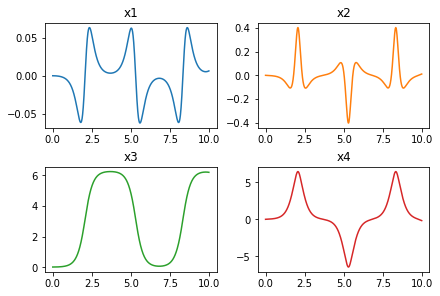

In [4]:
fig, axs = plt.subplots(2, 2, constrained_layout=True)
axs[0, 0].plot(t, state_list[:, 0])
axs[0, 0].set_title("x1")
axs[0, 1].plot(t, state_list[:, 1], "tab:orange")
axs[0, 1].set_title("x2")
axs[1, 0].plot(t, state_list[:, 2], "tab:green")
axs[1, 0].set_title("x3")
axs[1, 1].plot(t, state_list[:, 3], "tab:red")
axs[1, 1].set_title("x4")

plt.plot()

In [5]:
process_dynamics = inverted_pendulum.dynamics_continuous_sym()
dynamics_jacobian_x = process_dynamics.jacobian(sp.symbols("x1:5"))
A_c = dynamics_jacobian_x.evalf(subs={'x1': 0.0, 'x2': 0.0, 'x3':0.0, 'x4':0.0})
A_c = np.array(A_c).astype(np.float64)

dynamics_jacobian_u = process_dynamics.jacobian([sp.symbols("u")])
B_c = dynamics_jacobian_u.evalf(subs={'x1': 0.0, 'x2': 0.0, 'x3':0.0, 'x4':0.0})
B_c = np.array(B_c).astype(np.float64)

In [6]:
# Euler forward discretization of system
A_d = np.eye(A_c.shape[0]) + Ts * A_c
B_d = Ts * B_c

# LQR Controller Design
## Wikipedia:
the optimal control sequence minimizing the performance index is given by:
$$
u_{k}=-Fx_{k}\,
$$
where:
$$
F=(R+B^{T}PB)^{{-1}}(B^{T}PA+N^{T})\,
$$
and $P$ is the unique positive definite solution to the discrete time algebraic Riccati equation (DARE). $P$ can be found by iterating the dynamic Riccati equation until it converges:
$$
P_{{k-1}}=A^{T}P_{k}A-(A^{T}P_{k}B+N)\left(R+B^{T}P_{k}B\right)^{{-1}}(B^{T}P_{k}A+N^{T})+Q
$$ 
from terminal condition $P_{N}=Q$.

In [8]:
R = 1
Q = np.eye(A_d.shape[0])
Q[0,0] = Q[2,2] = 10

P = Q

while True:
    P_new = A_d.transpose() @ P @ A_d - (A_d.transpose() @ P @ B_d) @ np.linalg.inv(R + B_d.transpose() @ P @ B_d) @ (B_d.transpose() @ P @ A_d) + Q
    if np.linalg.norm(P-P_new) < 1e-5:
        P = P_new
        break
    else:
        P = P_new
        
print(P)

[[5.15125854e+03 1.31839760e+04 7.20344350e+04 2.29989090e+04]
 [1.31839760e+04 5.91592692e+04 3.47348745e+05 1.10820377e+05]
 [7.20344350e+04 3.47348745e+05 8.19533674e+06 2.55345323e+06]
 [2.29989090e+04 1.10820377e+05 2.55345323e+06 7.95772487e+05]]


In [12]:
F_inf = np.linalg.inv(R + B_d.transpose() @ P @ B_d) @ (B_d.transpose() @ P @ A_d)

lqr_controller = lambda x: -F_inf @ x

t = []
inverted_pendulum.set_controller(lqr_controller)

inverted_pendulum.set_state(np.array([0.0, 0.0, 0.01, 0.0]))
for i in range(iterations):
    t.append(i * Ts)
    state_list[i, :] = inverted_pendulum.integrate_dynamics(Ts)

<string>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[]

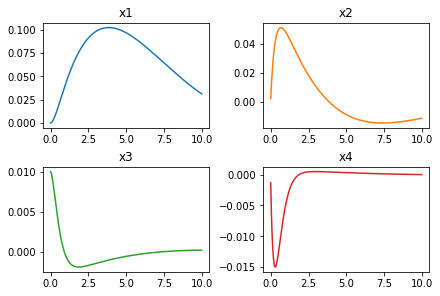

In [13]:
fig, axs = plt.subplots(2, 2, constrained_layout=True)
axs[0, 0].plot(t, state_list[:, 0])
axs[0, 0].set_title("x1")
axs[0, 1].plot(t, state_list[:, 1], "tab:orange")
axs[0, 1].set_title("x2")
axs[1, 0].plot(t, state_list[:, 2], "tab:green")
axs[1, 0].set_title("x3")
axs[1, 1].plot(t, state_list[:, 3], "tab:red")
axs[1, 1].set_title("x4")

plt.plot()